<center><h1>Group 2404 </h1></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name          | First Name            |Student Number|
|--------------------|-----------------------|----------------|
| Malagoli           | Pietro                |2125711         |
| Boccanera          | Eugenia               |2109310         |
| Braidi             | Federico              |2122169         |
| Lovato             | Matteo                |2104269         |           

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D

### Read data

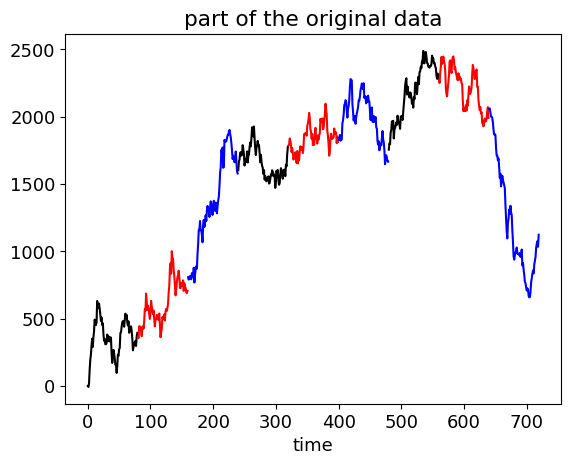

data:  4000


In [4]:
def Show_data(x,L,s="data",T=3):
    c=("k","r","b")
    for i in range(T):
        j=i*3*L
        plt.plot(np.arange(j,j+L),x[i*3],c=c[0])
        plt.plot(np.arange(j+L,j+2*L),x[i*3+1],c=c[1])
        plt.plot(np.arange(j+2*L,j+3*L),x[i*3+2],c=c[2])
    plt.title(s)
    plt.xlabel("time")
    plt.show()
    
str0="ts_L80_N4000.dat"
fnamex='x_'+str0
fnamey='y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"part of the original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Rescale data, split train/val.

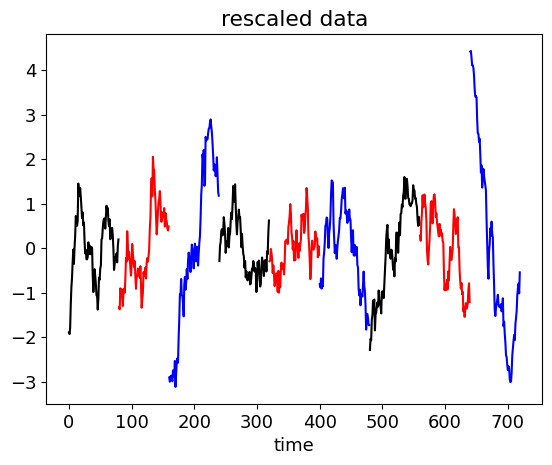

N_train= 3200   N_val= 800   L= 80   n_class= 3


In [5]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
# bring each sample to zero average
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x / x.std()
    
Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

### Convolutional NN

In [6]:
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

NCONV=2

def build_model(NCONV=1, NF=5,KS=6, NF2=5,KS2=4, lamb=0):
    """
    filter = kernel
    NCONV=index of the CNN architecture
    NF=nr of filters in the 1st layer
    KS=kernel size in the 1st layer
    NF2=nr of filters in the 2nd layer
    KS2=kernel size in the 2nd layer
    lamb=not the animal, but lambda, the regularization parameter
    """
    # regularizers, l2=Ridge, l1=LASSO
    reg = keras.regularizers.l2(lamb)
    model = Sequential()

    # Version with last layer Dense
    if NCONV==1:
        model.add(Conv1D(filters=NF, 
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        model.add(MaxPooling1D(3))
        #model.add(AveragePooling1D(3))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(Flatten())
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))

    # Version with last layer GlobalMaxPooling, one more intermediate conv1D, and no intermediate pooling
    if NCONV==2:
        model.add(Conv1D(filters=NF, 
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(tf.keras.layers.GlobalMaxPooling1D())
        model.add(Flatten())
        
    # Last layer, with n_class units  
    model.add(Dense(n_class, activation='softmax')) # softmax !
    
    # optimizers
    # .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
    # .RMSprop()
    # .Nadam()
    # Define the optimizer learning rate as a hyperparameter.
    # opt = keras.optimizers.Adam()
    
    # compile the model
    # categorical_crossentropy, 3 output nodes
    # model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])
    return model

model=build_model(NCONV=NCONV,KS=11)


print('----- Model',NCONV,'-----')
print(model.summary())

----- Model 2 -----
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 70, 5)             60        
                                                                 
 conv1d_1 (Conv1D)           (None, 67, 5)             105       
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 5)             105       
                                                                 
 global_max_pooling1d (Globa  (None, 5)                0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 3)                 18        
                                    

## Question 2: Testing Optimizers

In [31]:
lr=[10**(-1), 10**(-2), 10**(-3), 10**(-4), 10**(-5)]
BATCH_SIZE = 200
EPOCHS = 300

mean_accuracies_adam=[]
mean_accuracies_nadam=[]
mean_accuracies_rmsp=[]
mean_accuracies_sgd=[]

std_accuracies_adam=[]
std_accuracies_nadam=[]
std_accuracies_rmsp=[]
std_accuracies_sgd=[]

# ADAM
for i in range(0,len(lr)):
    adam=tf.keras.optimizers.Adam(learning_rate=lr[i])
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=adam,metrics=['accuracy'])
    print(model.layers)
    
    #Model Fitting with ADAM
    print('----- Model ADAM',NCONV,'-----\nFITTING....')
    fit_adam = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=0, shuffle=True) 
    print("end of fit")
    mean_adam_acc=np.mean(fit_adam.history['val_accuracy'])
    std_adam_acc=np.std(fit_adam.history['val_accuracy'])
    mean_accuracies_adam.append(mean_adam_acc)
    std_accuracies_adam.append(std_adam_acc)

#mean_accuracies.append(mean_accuracies_adam)    
# nADAM
for i in range(0,len(lr)):
    nadam=tf.keras.optimizers.Nadam(learning_rate=i)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=nadam,metrics=['accuracy'])
    print(model.layers)
    
    #Model Fitting with nADAM
    print('----- Model nADAM',NCONV,'-----\nFITTING....')
    fit_nadam = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=0, shuffle=True) 
    print("end of fit")
    mean_nadam_acc=np.mean(fit_nadam.history['val_accuracy'])
    std_nadam_acc=np.std(fit_nadam.history['val_accuracy'])
    mean_accuracies_nadam.append(mean_nadam_acc)
    std_accuracies_nadam.append(std_nadam_acc)

#mean_accuracies.append(mean_accuracies_nadam)    
# RMSprop
for i in range(0,len(lr)):
    rmsp=tf.keras.optimizers.RMSprop(learning_rate=i)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=rmsp,metrics=['accuracy'])
    print(model.layers)
    
    #Model Fitting with RMSprop
    print('----- Model RMS Prop',NCONV,'-----\nFITTING....')
    fit_rmsp = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=0, shuffle=True) 
    print("end of fit")
    mean_rmsp_acc=np.mean(fit_rmsp.history['val_accuracy'])
    std_rmsp_acc=np.std(fit_rmsp.history['val_accuracy'])
    mean_accuracies_rmsp.append(mean_rmsp_acc)
    std_accuracies_rmsp.append(std_rmsp_acc)

#mean_accuracies.append(mean_accuracies_rmsp)   
# SGD
for i in range(0,len(lr)):
    sgd=tf.keras.optimizers.SGD(learning_rate=i)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,metrics=['accuracy'])
    print(model.layers)
    
    #Model Fitting with SGD
    print('----- Model SGD',NCONV,'-----\nFITTING....')
    fit_sgd = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=0, shuffle=True) 
    print("end of fit")
    mean_sgd_acc=np.mean(fit_sgd.history['val_accuracy'])
    std_sgd_acc=np.std(fit_sgd.history['val_accuracy'])
    mean_accuracies_sgd.append(mean_sgd_acc)
    std_accuracies_sgd.append(std_sgd_acc)


[<keras.layers.convolutional.conv1d.Conv1D object at 0x0000022B03BCC970>, <keras.layers.convolutional.conv1d.Conv1D object at 0x0000022B03BCC910>, <keras.layers.convolutional.conv1d.Conv1D object at 0x0000022B03BCD4E0>, <keras.layers.pooling.global_max_pooling1d.GlobalMaxPooling1D object at 0x0000022B03BCD2A0>, <keras.layers.reshaping.flatten.Flatten object at 0x0000022B03D2D6C0>, <keras.layers.core.dense.Dense object at 0x0000022B0D98D1E0>]
----- Model ADAM 2 -----
FITTING....
end of fit
[<keras.layers.convolutional.conv1d.Conv1D object at 0x0000022B03BCC970>, <keras.layers.convolutional.conv1d.Conv1D object at 0x0000022B03BCC910>, <keras.layers.convolutional.conv1d.Conv1D object at 0x0000022B03BCD4E0>, <keras.layers.pooling.global_max_pooling1d.GlobalMaxPooling1D object at 0x0000022B03BCD2A0>, <keras.layers.reshaping.flatten.Flatten object at 0x0000022B03D2D6C0>, <keras.layers.core.dense.Dense object at 0x0000022B0D98D1E0>]
----- Model ADAM 2 -----
FITTING....
end of fit
[<keras.laye

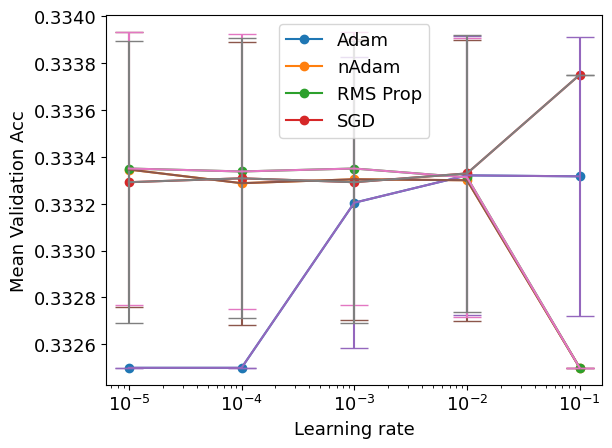

In [40]:
plt.plot(lr,mean_accuracies_adam,'o-',label='Adam')
plt.plot(lr,mean_accuracies_nadam,'o-',label='nAdam')
plt.plot(lr,mean_accuracies_rmsp,'o-',label='RMS Prop')
plt.plot(lr,mean_accuracies_sgd,'o-',label='SGD')
plt.errorbar(lr,mean_accuracies_adam,yerr=std_accuracies_adam,capsize=10)
plt.errorbar(lr,mean_accuracies_nadam,yerr=std_accuracies_nadam,capsize=10)
plt.errorbar(lr,mean_accuracies_rmsp,yerr=std_accuracies_rmsp,capsize=10)
plt.errorbar(lr,mean_accuracies_sgd,yerr=std_accuracies_sgd,capsize=10)
plt.legend()
#plt.grid()
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Mean Validation Acc')
plt.show()

#### Function to show weights

In [ ]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m','k',"gray","cyan","g"]
    m=['o','s','D','<','>','^','+','x','d',"*"]
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i%len(c)],marker=m[i%len(m)],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i%len(c)],marker=m[i%len(m)],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

#### Fitting

In [ ]:
# Hyper-parameters
# with small minibatch it does not converge!! 
BATCH_SIZE = 200
EPOCHS = 300

print('----- Model ',NCONV,'-----\nFITTING....')
fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True) 
print("end of fit")

#### Training VS Validation (Accuracy & Loss)

In [ ]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()
Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

### Confusion Matrix plot

In [ ]:
import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

LABELS = ["Class 0","Class 1","Class 2"]

def show_confusion_matrix(validations, predictions, label="Model",perc=False):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    M = matrix
    f = 'd'
    cmap="GnBu"
    if perc:
        M=M/np.sum(M)
        f='.2%'
        cmap='Blues'
    seaborn.heatmap(M,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt=f,
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = np.array(model.predict(x_val))
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val)
show_confusion_matrix(max_y_val, max_y_pred_val,perc=True)

# Adding Regularization 

In [ ]:
model2 = keras.models.clone_model(model)

reg2 = keras.regularizers.l2(0.5)
model2.layers[0].kernel_regularizer = reg2
model2.layers[1].kernel_regularizer = reg2
model2.layers[2].kernel_regularizer = reg2

opt = tf.keras.optimizers.legacy.Adam()
model2.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

BATCH_SIZE2 = 200
EPOCHS2 = 300

fit2 = model2.fit(x_train,y_train,batch_size=BATCH_SIZE2,epochs=EPOCHS2,
                validation_data=(x_val, y_val), verbose=2, shuffle=True) 

## Evaluation Plotting - Model w. Regularization

In [ ]:
Show_history(fit)
Show_history(fit2)

Show_weights(model,0,label="model1")
Show_weights(model2,0,label="model2")
Show_weights(model,2,label="model1")
Show_weights(model2,2,label="model2")


y_pred_val2 = model2.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val2 = np.argmax(y_pred_val2, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val, label="Model 1")
show_confusion_matrix(max_y_val, max_y_pred_val2, label="Model 2")